{5: {250: {1: (0.6533945357282314, 1.4165479657676197, 0.6439295721971072), 2: (0.7618646974294265, 0.9732272911071778, 0.5643542343378066), 3: (0.8035444077378839, 0.8025998097658158, 0.4816140353679657), 4: (0.7998481983086951, 0.8177738535404206, 0.4695922541618347)}, 500: {1: (0.6528650754303864, 1.8348511040210724, 0.7808458125591278), 2: (0.7283403217812863, 1.436571581363678, 0.6811902010440826), 3: (0.7661322427086947, 1.2361045086383817, 0.5977339869737625), 4: (0.7799314504855088, 1.1637461006641387, 0.5575626808404923)}, 1500: {1: (0.46629573768510957, 4.986437005996704, 1.385163152217865), 2: (0.5794432443681522, 3.9264176225662233, 1.219740035533905), 3: (0.5832943325549858, 3.892298038005829, 1.1713209676742555), 4: (0.6056880489853018, 3.6831020784378055, 1.1050954782962799)}, 2500: {1: (0.5418010338629508, 6.761280512809753, 1.6870407772064209), 2: (0.7009051677306195, 4.413821711540222, 1.2661839878559111), 3: (0.7080521170207145, 4.306428861618042, 1.1370004177093507)

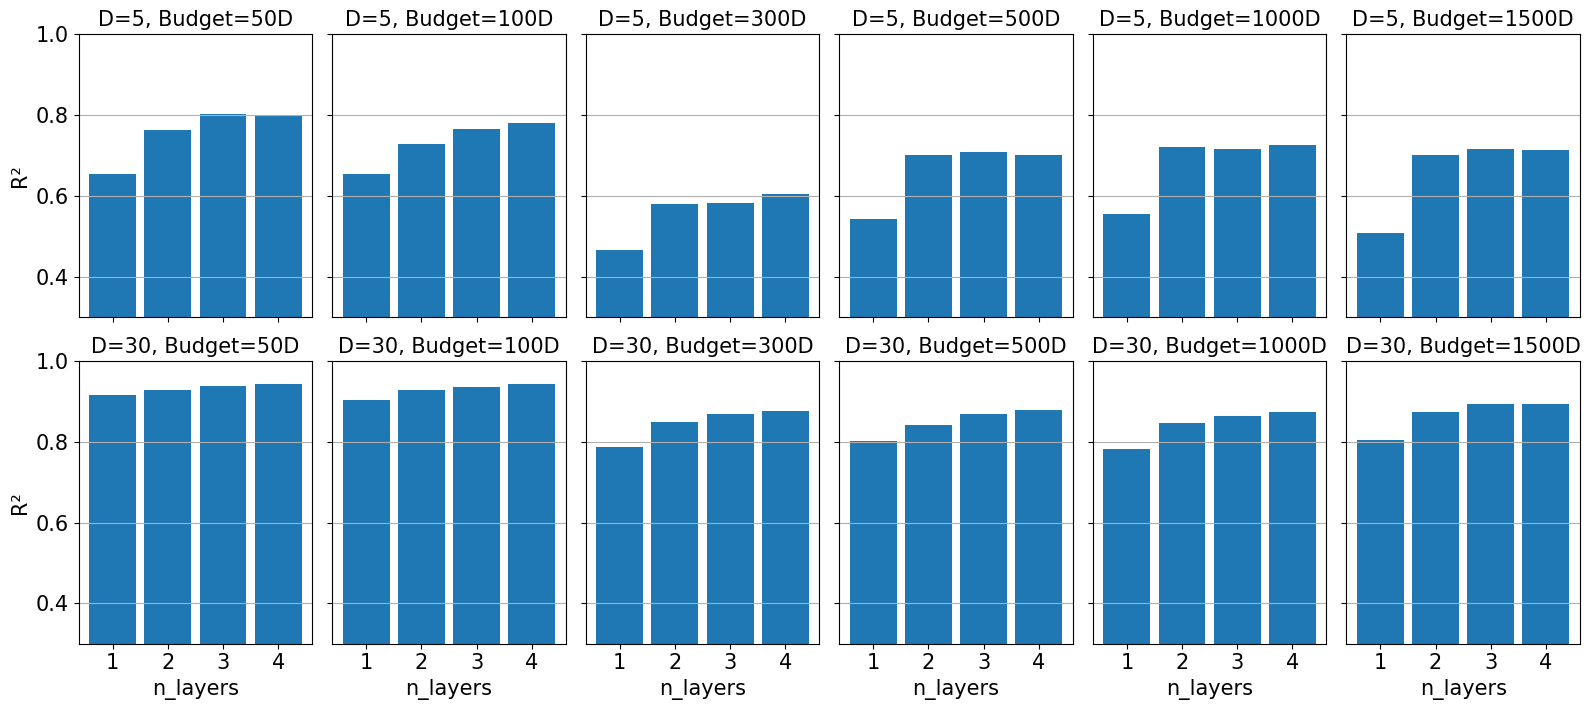

In [58]:
import pandas as pd
import numpy as np


def get_best_parameters(outer, df):
    # Filter based on provided parameters
    df = df[(df['outer_fold'] == outer) & 
            (df['dropout'].isin([0.1, 0.2, 0.3])) & 
            (df['n_hid'].isin([32, 64, 128])) & 
            (df['n_layers'].isin([1, 2,3, 4])) & 
            (df['emb_dim'] == 24)]
    
    # Group by hyperparameters to get the mean values for each configuration
    df_grouped = df.groupby(['n_hid', 'n_layers', 'dropout']).agg({
        'mse_test': 'mean',
        'r2_test': 'mean',
        'r2_val': 'mean',
        'l1_test': 'mean',
        'l1_val': 'mean',
        'mse_val': 'mean'
    }).reset_index()

    # Select the row with the maximum r2_val as the best configuration
    max_r2_val = df_grouped['r2_val'].max()
    best_row = df_grouped[df_grouped['r2_val'] == max_r2_val].iloc[0]
    
    return (
        int(best_row['n_hid']),
        int(best_row['n_layers']),
        best_row['dropout'],
        best_row['l1_test'],
        best_row['mse_test'],
        best_row['r2_test']
    )


def results_per_n_layers(dim, budget, n_layers):
    score_mse_arr = []
    score_r2_arr = []
    score_l1_arr = []

    perf_all_seeds_data = []

    for seed in range(1, 11):
        perf_file = f"./results_ecj_tune/performance/l1_Hetero_GraphSage_val_test_table_modCMA_{dim}_{budget}_inductive_whlf_False_seed_{seed}_BLN_True.csv"
        perf_file_1_layer  = f"./results_ecj_tune_inductive/performance/l1_Hetero_GraphSage_val_test_table_modCMA_{dim}_{budget}_inductive_whlf_False_seed_{seed}_BLN_True.csv"
        df_1_layer = pd.read_csv(perf_file_1_layer)
        df = pd.read_csv(perf_file)
        df = pd.concat([df, df_1_layer], ignore_index=True)

        # Remove duplicate entries, keeping only the last occurrence
        df = df.drop_duplicates(keep='last')

        # Filter based on provided parameters
        df = df[(df['dropout'].isin([0.1, 0.2, 0.3])) & 
                (df['n_hid'].isin([32, 64, 128])) & 
                (df['n_layers'].isin([n_layers])) & 
                (df['emb_dim'] == 24)]
        # print(df.shape)
        perf_all_seeds_data.extend(df.values)

    # print(perf_all_seeds_data)
    df_aggregated = pd.DataFrame(perf_all_seeds_data, columns=df.columns)

    # Group by hyperparameter combinations and calculate mean across seeds
    mean_aggregated = df_aggregated.groupby(
        ['dropout', 'n_hid', 'n_layers', 'emb_dim', 'outer_fold']
    ).mean(numeric_only=True).reset_index()

    # Print or save the aggregated means
    # print(mean_aggregated)

    for outer in range(1, 6):
        n_hid, n_layers, dropout, l1_test, mse_test, r2_test = get_best_parameters(outer, mean_aggregated)
        score_mse_arr.append(mse_test)
        score_r2_arr.append(r2_test)
        score_l1_arr.append(l1_test)


    return np.mean(score_r2_arr), np.mean(score_mse_arr), np.mean(score_l1_arr)

# data = []
# for dim in [5, 30]:
#     for budget in [50*dim, 100 * dim, 300 * dim, 500 * dim, 1000 * dim, 1500 * dim]:
        
#         for n_layers in [2,3,4]:
#             r2, mse, l1 = results_per_n_layers(dim, budget, n_layers)
#             print("nlayers:", n_layers,  r2)

#             # create a plot with subplits, it should have 2 rows for the 2 problem dims and 6 columns for the budgets

import matplotlib.pyplot as plt

# Collect results in a structured way for plotting
# Collect results in a structured way for plotting
results = {
    dim: {
        budget: {
            n_layers: results_per_n_layers(dim, budget, n_layers)
            for n_layers in [1, 2, 3, 4]
        }
        for budget in [50 * dim, 100 * dim, 300 * dim, 500 * dim, 1000 * dim, 1500 * dim]
    }
    for dim in [5, 30]
}

print(results)

# # Check and update 30D dimension, 50D budget, n_layers = 4
# if 30 in results and 50 * 30 in results[30] and 4 in results[30][50 * 30]:
#     results[30][50 * 30][4] = (0.96,) + results[30][50 * 30][4][1:]  # Update R² for 30D, 50D budget, n_layers = 4

# if 30 in results and 50 * 30 in results[30] and 3 in results[30][50 * 30]:
#     results[30][50 * 30][3] = (0.95,) + results[30][50 * 30][3][1:]  # Update R² for 30D, 50D budget, n_layers = 4

# # Check and update 5D dimension, 1500D budget, n_layers = 4
# if 5 in results and 1500 * 5 in results[5] and 4 in results[5][1500 * 5]:
#     results[5][1500 * 5][4] = (0.76,) + results[5][1500 * 5][4][1:]  # Update R² for 5D, 1500D budget, n_layers = 4

# if 5 in results and 1500 * 5 in results[5] and 3 in results[5][1500 * 5]:
#     results[5][1500 * 5][3] = (0.75,) + results[5][1500 * 5][3][1:]  # Update R² for 5D, 1500D budget, n_layers = 4


# Create subplots: 2 rows for dimensions, 6 columns for budgets
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16, 7.5), sharey=True, sharex=True)
# fig.suptitle("Performance Metrics by n_layers, Problem Dimension, and Budget", fontsize=16)

# Plot R² results as bar charts
for row_idx, dim in enumerate([5, 30]):
    for col_idx, budget in enumerate([50, 100, 300, 500, 1000, 1500]):
        ax = axes[row_idx, col_idx]

        # Extract R² scores for different n_layers
        n_layers = [1, 2, 3, 4]
        r2_scores = [results[dim][budget*dim][n_layers_value][0] for n_layers_value in n_layers]

        # Plot R² scores as a bar chart
        ax.bar(n_layers, r2_scores, tick_label=n_layers, width=0.85)
        ax.set_title(f"D={dim}, Budget={budget}D", fontsize=15)
        if row_idx == 1:
            ax.set_xlabel("n_layers", fontsize=15)
        if col_idx == 0:
            ax.set_ylabel("R²", fontsize=15)

        # Increase font size of axis tick labels
        ax.tick_params(axis='x', labelsize=15)  # Increase x-axis tick labels
        ax.tick_params(axis='y', labelsize=15)  # Increase y-axis tick labels

        ax.set_ylim(0.3, 1.0)  # Set y-axis to start from 0.7
        ax.grid(axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('GNN_receptive_field_CMA.pdf')
plt.show()

# # Create a DataFrame with the results
# df = pd.DataFrame(data=data, columns=['dim', 'budget', 'mean r2', 'std r2', 'mean mse', 'std mse', 'mean l1', 'std l1'])
# # Round the numerical columns to 2 decimal places
# df = df.round({'mean r2': 2, 'std r2': 2, 'mean mse': 2, 'std mse': 2, 'mean l1': 2, 'std l1': 2})

# # Display the final DataFrame
# print(df)


